In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.utils import resample

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
!pip install pandas_datareader

     |████████████████████████████████| 112kB 1.7MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
def selection_size(sample):
    obs = len(sample)
    r0 = 0.01 + 1.8/np.sqrt(obs)
    swindow0 = np.floor(r0*obs)
    dim = obs - swindow0 + 1
    # select year automatically from sample, for pandas_datareader, is 5 years
    yr = 5
    Tb = 12*yr + swindow0 + 1
    nboot = 999
    return obs, r0, swindow0, dim, Tb, nboot

In [4]:
def auto_corr(sample):
    dataframe = pd.DataFrame(sample)
    for i in range(1,3):
        dataframe = pd.concat([dataframe.shift(i), dataframe], axis=1)
    dataframe.columns = ['V1','V2', 'V3','V4']
    result = dataframe.corr()
    return result

In [5]:
def ar_selection(sample):
    model = AR(sample)
    model_fit = model.fit
    return model_fit

In [7]:
import pandas_datareader.data as pdr

In [8]:
spy_table = pdr.get_data_yahoo('SPY')

In [57]:
data = spy_table.loc['2015',['Close']]
data = data['Close']
print(data.head())


Date
2015-02-11    206.929993
2015-02-12    208.919998
2015-02-13    209.779999
2015-02-17    210.110001
2015-02-18    210.130005
Name: Close, dtype: float64


In [30]:
print(auto_corr(data))

          V1        V2        V3        V4
V1  1.000000  0.940035  0.872855  0.819700
V2  0.940035  1.000000  0.939889  0.872068
V3  0.872855  0.939889  1.000000  0.939629
V4  0.819700  0.872068  0.939629  1.000000


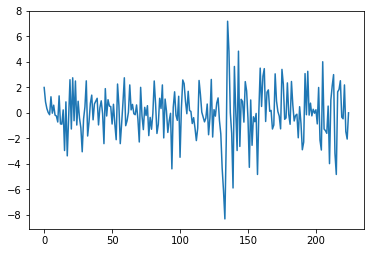

In [60]:
sample = np.zeros(len(data))
for i in range(len(data)-1):
    sample[i] = data[i+1] - data[i]
plt.plot(sample)

In [61]:
obs = int(selection_size(data)[0])
swindow0 = int(selection_size(data)[2])
Tb = int(selection_size(data)[4])

In [62]:
maxlag = int(np.ceil(12.*np.power(obs/100., 1/4.)))
maxlag = min(obs//2 - 1, maxlag)
model = AR(data)
type(model)
model_fit = model.fit(maxlag = maxlag, method = 'cmle', ic='aic', disp=1, maxiter=1000)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
print(model_fit.resid)
adflag = model_fit.k_ar

Lag: 1
Coefficients: const       12.361378
L1.Close     0.940090
dtype: float64
Date
2015-02-12    2.025757
2015-02-13    1.014973
2015-02-17    0.536497
2015-02-18    0.246270
2015-02-19    0.077455
2015-02-20    1.478487
2015-02-23    0.263965
2015-02-24    0.892158
2015-02-25    0.148119
2015-02-26    0.067329
2015-02-27   -0.417650
2015-03-02    1.589218
2015-03-03   -0.531114
2015-03-04   -0.603225
2015-03-05    0.463465
2015-03-06   -2.712772
2015-03-09    0.929902
2015-03-10   -3.258581
2015-03-11   -0.561068
2015-03-12    2.490178
2015-03-13   -1.224067
2015-03-16    2.719852
2015-03-17   -0.485391
2015-03-18    2.597460
2015-03-19   -0.712772
2015-03-20    1.099724
2015-03-23   -0.165765
2015-03-24   -0.960317
2015-03-25   -2.911030
2015-03-26   -0.524333
                ...   
2015-11-18    3.208279
2015-11-19   -0.036403
2015-11-20    0.892801
2015-11-23   -0.061653
2015-11-24    0.443959
2015-11-25    0.150736
2015-11-27    0.418927
2015-11-30   -0.676680
2015-12-01    2.13

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
def psy(model_fit, sample):  
    eb = resample(model_fit.resid, n_samples = swindow0, random_state = 1)
    yb = sample
    for i in range(swindow0):
        eb[i] = eb[i] * np.random.normal()
    for i in range(swindow0):
        yb[i] = yb[i] + eb[i]
    result = adfuller(yb)[0]
    return result,yb

In [15]:
def flatten(a):
    for each in a:
        if not isinstance(each. list):
            yield each
        else:
            yield from flatten(each)
    return a

In [16]:
#result, yb = psy(model_fit, sample)
#print(yb)
np.zeros([5,2])

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [63]:
#adflag = model_fit.k_ar
def ADF(x,adflag):
    # creating independent matrix for adf regression 
    cons = np.repeat(1,len(x)-adflag-1)
    trend = np.zeros(len(x)-adflag-1)
    for i in range(len(trend)):
        trend[i] = i
    dx = np.zeros([len(x)-adflag-1,adflag])
    for k in range(adflag):
        if k == 0:
            for i in range(len(x)-adflag-1):
                dx[i,k] = x[i+1]-x[i]
        elif k >0:
            for i in range(len(x)-adflag-1):
                dx[i,k]=(dx[i,k-1] - dx[i-1,k-1])    
    
    df = np.column_stack((cons,trend,x[0:len(x)-adflag-1],dx))
    dy = np.zeros(len(x)-adflag-1)
    for i in range(len(x)-adflag-1):
        dy[i] = x[i+adflag+1] - x[i+adflag]
    
    #calculating OLS estimators
    beta = np.linalg.inv(df.transpose()@df)@(df.transpose()@dy)
    eps = dy - df@beta
    se = eps.transpose()@eps/(len(x)-adflag-3)
    a = np.diag(np.repeat(se,adflag+3))
    b = np.linalg.inv(df.transpose()@df)
    sigma = np.sqrt(a@b)
    adfstat = beta[2]/sigma[2,2]
    return adfstat
#sort(critical_value)
#chose 95% index 
print(ADF(data,8))


-1.1747735245240858


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in sqrt


In [18]:
adfuller(sample[3:1000])

(-12.089278305272368,
 2.1412428515864594e-22,
 7,
 989,
 {'1%': -3.436979275944879,
  '5%': -2.8644668170148058,
  '10%': -2.5683283824496153},
 4156.198786553378)

In [64]:
def bsadf(data,swindow0):
    critical_value = []
    t2 = swindow0
    while t2 <= obs:
        k = 0
        while k < t2 - swindow0:
            critical_value.append(ADF(data[k:t2],1))
            k = k+1
        t2 = t2+1
    return(critical_value)

In [65]:
bsadf(data,swindow0)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in sqrt


[-1.925096761166443,
 -1.8754727662817106,
 -1.700828963944228,
 -2.0380534015360703,
 -1.8490537082755054,
 -1.7969245148944886,
 -2.3404934682806666,
 -2.1441523546695267,
 -2.0711697362758197,
 -2.0408686582445132,
 -2.370453338514814,
 -2.172064716551215,
 -2.1047169830722816,
 -2.081661158527995,
 -2.081156612665082,
 -2.405744438300938,
 -2.224703391915397,
 -2.1683043037654057,
 -2.1525292115803585,
 -2.1577181742279077,
 -2.028085181802841,
 -2.4920618999231783,
 -2.296002232813828,
 -2.231417756172182,
 -2.2104738116037557,
 -2.2114090040860837,
 -2.0753657781733716,
 -2.015983818237562,
 -2.5421269501270447,
 -2.336778502506134,
 -2.2605206268510463,
 -2.2287162395913964,
 -2.21817412987824,
 -2.0747708015658444,
 -2.0132703292589587,
 -1.9991235967204835,
 -2.576780397682039,
 -2.370158292483523,
 -2.294296156259311,
 -2.2626150420011397,
 -2.251294817375812,
 -2.1146570549080286,
 -2.0553575603243504,
 -2.048237919195635,
 -2.0474119615690447,
 -2.5203731685714783,
 -2.3027